In [43]:
import sys
sys.path.append(r'C:\Users\USER\Documents\GitHub\frft')
sys.path.append(r'C:\Users\USER\Documents\GitHub\DLOCT\Analysis_cGAN')
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, fftshift, ifft,fft2,ifft2
import sys
from tqdm import tqdm # for progress bars
from statistics import mean, stdev
from scipy.signal import find_peaks
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import plotly.express as px
# Repositorio
sys.path.append(r'C:\Users\USER\Documents\GitHub\frft') 
import torch
import frft
import frft_gpu as frft_g
import time
from Deep_Utils import dbscale
from PyEMD import EMD
from scipy.signal import hilbert

def extract_dimensions(file_name):
    parts = file_name.split('_')
    dimensions = []
    for part in parts:
        if 'z=' in part or 'x=' in part or 'y=' in part:
            number = int(part.split('=')[-1])
            dimensions.append(number)
    return tuple(dimensions)

def read_tomogram(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width),order='F')
    return tomogram

In [2]:
pathcomplex = r'C:\Users\USER\Documents\GitHub\[s.fovea]11bscan'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram(real_file_path, dimensions)
        tomImag = read_tomogram(imag_file_path, dimensions)
        tomcc = tomReal + 1j * tomImag
        del tomImag, tomReal


pathcomplex = r'C:\Users\USER\Documents\GitHub\[s.fovea]11bscanNoartifacts'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram(real_file_path, dimensions)
        tomImag = read_tomogram(imag_file_path, dimensions)
        tom = tomReal + 1j * tomImag
        del tomImag, tomReal


In [126]:
fringescc = fftshift(ifft(tomcc,axis=0),axes=0)
fringes = fftshift(ifft(tom,axis=0),axes=0)
aline = 512
bscan = 0
singlecc = fringescc[:,aline,bscan]
single = fringes[:,aline,bscan]

In [79]:
fig = make_subplots(rows=3, cols=1)
fig.add_trace(
    go.Scatter(y=np.real(singlecc), mode='lines', name='artifacts fringes'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(y=np.real(single), mode='lines', name='no artifacts real part'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=np.imag(single), mode='lines', name='no artifacts image part'),
    row=3, col=1
)
fig.update_layout(
    title_text="Análisis de Señales",
    height=900,  # Ajusta la altura si es necesario
    showlegend=False
)
fig.update_xaxes(title_text="artifacts fringes", row=1, col=1)
fig.update_xaxes(title_text="no artifacts real part", row=2, col=1)
fig.update_xaxes(title_text="no artifacts image part", row=3, col=1)
fig.show()

In [86]:
emd = EMD()
imfs_real = emd(np.real(single))
imfs_imag = emd(np.imag(single))
imfscc = emd(np.real(singlecc))

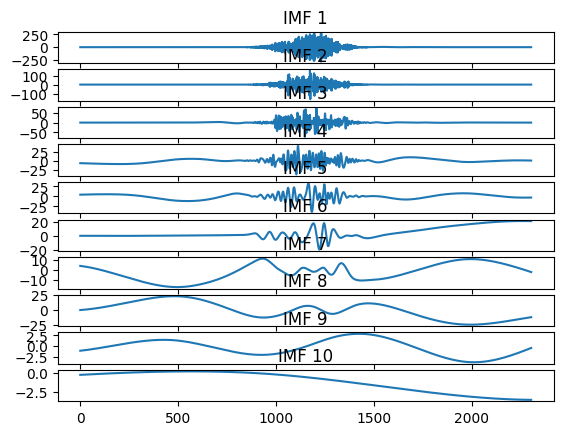

In [114]:

plt.figure()
for i in range(len(imfs_real)):
    plt.subplot(len(imfs_real), 1, i+1)
    plt.plot(imfs_real[i])
    plt.title(f'IMF {i+1}')
plt.show()

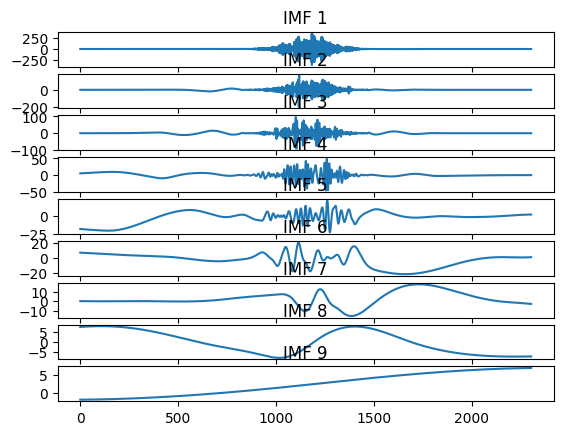

In [88]:
plt.figure()
for i in range(len(imfs_imag)):
    plt.subplot(len(imfs_imag), 1, i+1)
    plt.plot(imfs_imag[i])
    plt.title(f'IMF {i+1}')
plt.show()

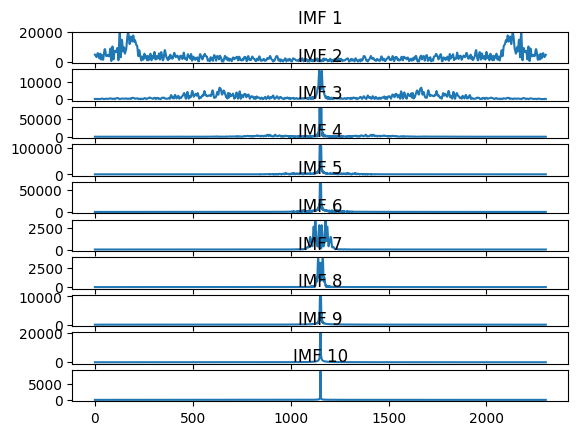

214229187.8767277
214239819.62085935


In [129]:
powerleft = 0
powerright = 0
plt.figure()
for i in range(len(imfscc)):
    fftimf = fftshift(fft(imfscc[i]))
    left = abs(np.sum(fftimf[0:int(len(fftimf)/2)]))**2/len(fftimf)/2
    right = abs(np.sum(fftimf[int(len(fftimf)/2):]))**2/len(fftimf)/2
    powerleft += left
    powerright += right
    plt.subplot(len(imfscc), 1, i+1)
    plt.plot(abs(fftimf))
    plt.title(f'IMF {i+1}')
plt.show()
print(powerleft)
print(powerright)

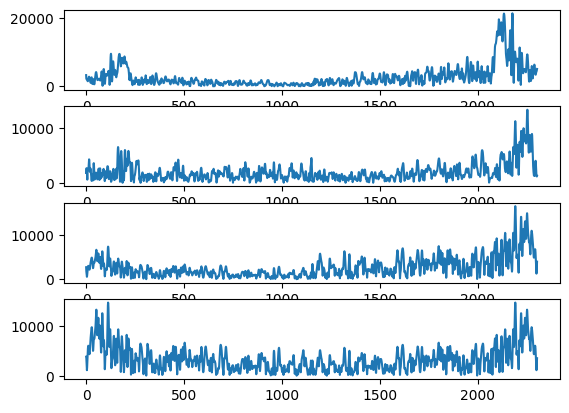

In [128]:
n=0
imf = (imfscc[n]+1j*hilbert(imfscc[n]))/2
analytic_signal = (np.real(singlecc) + 1j*hilbert(np.real(singlecc)))/2
fig, axs = plt.subplots(nrows =4,ncols = 1)
axs[0].plot((abs(fftshift(fft(imf)))))
axs[1].plot(abs(fftshift(fft(single))))
axs[2].plot((abs(fftshift(fft(analytic_signal)))))
axs[3].plot(abs(fftshift(fft(singlecc))))